<a href="https://colab.research.google.com/github/uteyechea/DCGAN-Faces-Generator/blob/main/celebA_dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Convolutional Generative Adversarial Network

## What are GANs?
[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A *generator* ("the artist") learns to create images that look real, while a *discriminator* ("the art critic") learns to tell real images apart from fakes.

![A diagram of a generator and discriminator](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan1.png?raw=1)

During training, the *generator* progressively becomes better at creating images that look real, while the *discriminator* becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.

![A second diagram of a generator and discriminator](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gan2.png?raw=1)

This notebook demonstrates this process on the MNIST dataset. The following animation shows a series of images produced by the *generator* as it was trained for 50 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.

![sample output](https://tensorflow.org/images/gan/dcgan.gif)

To learn more about GANs, we recommend MIT's [Intro to Deep Learning](http://introtodeeplearning.com/) course.

### Setup

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.4.1'

In [3]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-f4wqmapk
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-f4wqmapk
     |████████████████████████████████| 1.0MB 9.2MB/s 
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.01ee1b237a632139414f22f16e993535c2a48a68f_-cp36-none-any.whl size=147333 sha256=f14af04e445514c282bc7ddc85101f7be6867bab928aeef3dd7e3f9aeffba0c8
  Stored in directory: /tmp/pip-ephem-wheel-cache-h4oyvmpn/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully uninstalled protobuf-3.12.4


In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

import pathlib

from IPython import display

## Connect Google drive

In [5]:
#Mount my Google Drive 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#Define global path to working directory
data_dir='/content/drive/MyDrive/Colab Notebooks/celebA-dcgan/img_align_celeba'
#Create pathlib object
data_dir = pathlib.Path(data_dir)


Mounted at /content/drive


### Load and prepare the dataset

We will use the celebA dataset to train the generator and the discriminator. The generator will generate various celebrity faces and the discriminator will classify the face as being either real or fake.

Dataset info:
https://www.kaggle.com/jessicali9530/celeba-dataset

In [6]:
batch_size = 9
BATCH_SIZE = 9
img_height = 110# 220 Reduced to preserve memory .Adjusted for conv2d_transpose. # Original image height = 218
img_width = 90# 180 #Original image width = 178

In [18]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.0,
  #subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode=None) #None for unlabeled data
print(type(train_ds))

Found 41474 files belonging to 1 classes.
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order. Nevertheless, for our model this is redundant.

In [19]:
class_names = train_ds.class_names
print(class_names)

['img_align_celeba']


## Visualize the data

Here are the first 9 images from the training dataset.

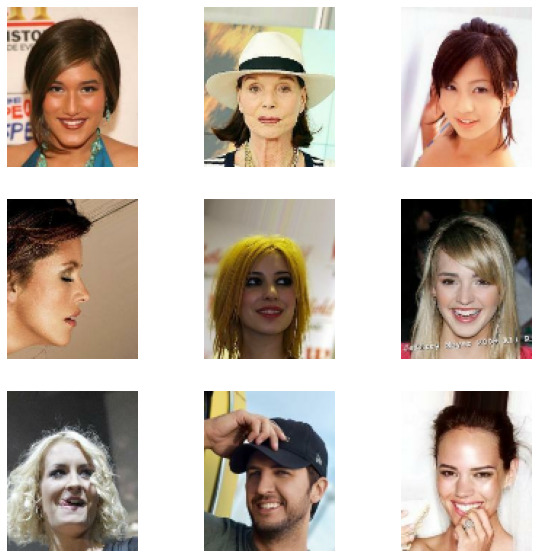

In [20]:
plt.figure(figsize=(10, 10))
for images in train_ds.take(1): #take(): Creates a Dataset with at most count elements from this dataset.
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

Momentarily, we will train a model using this dataset by passing them to our model. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [12]:
for image_batch in train_ds.take(1):
  print(image_batch.shape)
  #print(labels_batch.shape)
  break

(9, 110, 90, 3)


In [24]:
image_batch

<tf.Tensor: shape=(9, 110, 90, 3), dtype=float32, numpy=
array([[[[0.4801743 , 0.6409586 , 0.48409587],
         [0.5061438 , 0.6551634 , 0.5100654 ],
         [0.5071896 , 0.6522876 , 0.5189543 ],
         ...,
         [0.3464606 , 0.52293116, 0.36214688],
         [0.21374238, 0.39021298, 0.22942865],
         [0.227451  , 0.38823533, 0.22352943]],

        [[0.4801743 , 0.6409586 , 0.48409587],
         [0.5061438 , 0.6551634 , 0.5100654 ],
         [0.5071896 , 0.6522876 , 0.5189543 ],
         ...,
         [0.33033857, 0.5068092 , 0.34602484],
         [0.21259187, 0.38906246, 0.22827815],
         [0.227451  , 0.38823533, 0.22352943]],

        [[0.4801743 , 0.6409586 , 0.48409587],
         [0.5061438 , 0.6551634 , 0.5100654 ],
         [0.5071896 , 0.6522876 , 0.5189543 ],
         ...,
         [0.3068725 , 0.4833431 , 0.32255876],
         [0.21074255, 0.38721317, 0.22642882],
         [0.227451  , 0.38823533, 0.22352943]],

        ...,

        [[0.03013665, 0.03013665, 0

## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [25]:
AUTOTUNE = tf.data.AUTOTUNE
n_samples=batch_size #assuming your train_ds has more than 1000 training samples
train_ds = train_ds.cache().shuffle(n_samples).prefetch(buffer_size=AUTOTUNE)

## Standardize the data (Values already in [0,1])

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the `[0, 1]` range by using a Rescaling layer.

In [26]:
#normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

Note: The Keras Preprocessing utilities and layers introduced in this section are currently experimental and may change.

You can apply it to the dataset by calling map:

In [27]:
"""
normalized_ds = train_ds.map(lambda x: (normalization_layer(x)))
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

# outputs [0.0, 1.0]
"""

'\nnormalized_ds = train_ds.map(lambda x: (normalization_layer(x)))\nimage_batch = next(iter(normalized_ds))\nfirst_image = image_batch[0]\n# Notice the pixels values are now in `[0,1]`.\nprint(np.min(first_image), np.max(first_image)) \n\n# outputs [0.0, 1.0]\n'

Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the first approach here.

In [28]:
#layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [29]:
def make_generator_model(img_height=img_height,img_width=img_width):
    model = tf.keras.Sequential()
  
    model.add(layers.Dense(11*9*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((11, 9, 256)))
    assert model.output_shape == (None, 11, 9, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 11, 9, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 22, 18, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(5, 5), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, img_height, img_width, 3)

    return model

### The Discriminator

The discriminator is a CNN-based image classifier.

In [30]:
def make_discriminator_model(img_height=img_height,img_width=img_width):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[img_height, img_width, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Use the (as yet untrained) generator to create an image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 110, 90, 3)


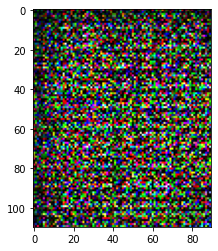

In [42]:
generator = make_generator_model()
noise = tf.random.uniform([1, 100],maxval=1)
generated_image = generator(noise, training=False)
print(generated_image.shape)
plt.imshow(generated_image[0, :, :, :]*255)

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [43]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00020861]], shape=(1, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [44]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [45]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [46]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [47]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [48]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [49]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [50]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [51]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [52]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :] * 255 )
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

In [ ]:
train(train_ds, EPOCHS)

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

## Next steps


This tutorial has shown the complete code necessary to write and train a GAN. As a next step, you might like to experiment with a different dataset, for example the Large-scale Celeb Faces Attributes (CelebA) dataset [available on Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset). To learn more about GANs we recommend the [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160).
